# [Distilling Policy Distillation](https://arxiv.org/abs/1902.02186)

*W. M. Czarnecki, R. Pascanu, S. Osindero, S. Jayakumar, G. Swirszcz, M. Jaderberg*

*PMLR, 2019*

Notebook written by Anthony Coache as part of his presentation in the "STA4273 - Minimizing Expectations" course.

## 1. Key ideas

In the original paper, they provide multiple large-scale experiments on some policy distillation methods known in the literature. All update rules considered by the authors have this form
\begin{equation*}
\mathbb{E}_{q_{\theta}} \left[ \sum_{t=1}^{|\tau|} - \nabla_{\theta} \log(\pi_{\theta} (a_t|s_t)) \sum_{i=t}^{|\tau|} \widehat{r}_i + \nabla_{\theta} \ell_t \right],
\end{equation*}
with the following parameters:
* the control policy $q_{\theta}$;
* the loss function $\ell_t$;
* the reward term $\widehat{r}_i$.

In this notebook, I will : 

1.   explore the effect of the control policy on distillation methods,
2.   reproduce some of their comparison results,
3.   extend the analysis to mixture of policies.

In [ ]:
#@title Import Python libraries

import numpy as np
import pandas as pd
import plotnine as gg
import tensorflow as tf

## 2. Creating a grid environment

We first need to define an environment similar to the Figure 7 in the original paper, which is a grid with rewards and penalties. I use the [GridWorld environment created by Jeremy Zhang](https://github.com/MJeremy2017/reinforcement-learning-implementation/blob/master/GridWorld/gridWorld.py) as a template to create a much more complex grid. Among others, I add:

* lists of rewards/costs on various states instead of a single reward/cost per grid,
* non-terminal states with -1 rewards,
* multiple categories of rewards/costs,
* a maximum number of time steps, to ensure finite length of trajectories.

Note that the rewards and penalties are deterministic. If you want to randomize the creation of this environment, one can follow the procedure given in the Appendix A.2 of the original paper.

In [ ]:
#@title Hyperparameters of the GridWorld class

grid_rows = 10 #@param {type:"integer"}
grid_cols = 10 #@param {type:"integer"}
max_steps = 20 #@param {type:"integer"}
plus10_states = [(2,9),(6,1)] #@param {type:"raw"}
plus5_states = [(9,6)] #@param {type:"raw"}
minus10_states = [(8,8),(9,2),(6,6),(6,2)] #@param {type:"raw"}
minus5_states = [(8,1),(2,7),(3,9)] #@param {type:"raw"}
minus1_states = [(0,5),(0,8),(1,1),(1,2),(4,3),(7,5),(5,6),(5,4)] #@param {type:"raw"}
start = (5, 5) #@param {type:"raw"}

In [ ]:
#@title Grid world environment

class GridWorld:
  def __init__(self,
               start = (0,0),
               n_rows = 3,
               n_cols = 4,
               max_steps = 50,
               plus10_states = [(2,3)],
               plus5_states = [],
               minus10_states = [(1,2)],
               minus5_states = [],
               minus1_states = []):
    self.initial_state = start
    self.state = start
    self.n_rows = n_rows
    self.n_cols = n_cols

    self.steps = 1
    self.max_steps = max_steps
    self.n_actions = 4

    self.plus10_states = plus10_states
    self.plus5_states = plus5_states
    self.minus10_states = minus10_states
    self.minus5_states = minus5_states
    self.minus1_states = minus1_states
    
  def giveReward(self):
    if self.state in self.plus10_states:
      return 10
    elif self.state in self.plus5_states:
      return 5
    elif self.state in self.minus10_states:
      return -10
    elif self.state in self.minus5_states:
      return -5
    elif self.state in self.minus1_states:
      return -1
    else:
      return 0

  def isDone(self):
    if (self.state in self.plus10_states) or (self.state in self.minus10_states):
      return True
    elif (self.state in self.plus5_states) or (self.state in self.minus5_states):
      return True
    elif self.steps == self.max_steps:
      return True
    else:
      return False

  def nxtPosition(self, action):
    self.steps += 1
    if action == 0:
      nxtState = (self.state[0] - 1, self.state[1])
    elif action == 1:
      nxtState = (self.state[0] + 1, self.state[1])
    elif action == 2:
      nxtState = (self.state[0], self.state[1] - 1)
    else:
      nxtState = (self.state[0], self.state[1] + 1)
    # if next state legal
    if (nxtState[0] >= 0) and (nxtState[0] <= (self.n_rows -1)):
      if (nxtState[1] >= 0) and (nxtState[1] <= (self.n_cols -1)):
        if nxtState != (1, 1):
          self.state = nxtState

  def showBoard(self):
      for i in range(0, self.n_rows):
        print('-----------------')
        out = '| '
        for j in range(0, self.n_cols):
          if (i,j) == self.initial_state:
              token = '*'
          elif (i,j) in self.plus10_states:
              token = 'R'
          elif (i,j) in self.plus5_states:
              token = 'r'
          elif (i,j) in self.minus10_states:
              token = 'L'
          elif (i,j) in self.minus5_states:
              token = 'l'
          elif (i,j) in self.minus1_states:
              token = '-'
          else:
              token = '0'
          out += token + ' | '
        print(out)
      print('-----------------')

In [ ]:
#@title Visualize the GridWorld

env = GridWorld(start = start,
               n_rows = grid_rows,
               n_cols = grid_cols,
               max_steps = max_steps,
               plus10_states = plus10_states,
               plus5_states = plus5_states,
               minus10_states = minus10_states,
               minus5_states = minus5_states,
               minus1_states = minus1_states)
env.showBoard()

# Dimensions of the state and action spaces
obs_size = env.n_rows * env.n_cols
act_size = env.n_actions

-----------------
| 0 | 0 | 0 | 0 | 0 | - | 0 | 0 | - | 0 | 
-----------------
| 0 | - | - | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 0 | 0 | 0 | l | 0 | R | 
-----------------
| 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | l | 
-----------------
| 0 | 0 | 0 | - | 0 | 0 | 0 | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | - | * | - | 0 | 0 | 0 | 
-----------------
| 0 | R | L | 0 | 0 | 0 | L | 0 | 0 | 0 | 
-----------------
| 0 | 0 | 0 | 0 | 0 | - | 0 | 0 | 0 | 0 | 
-----------------
| 0 | l | 0 | 0 | 0 | 0 | 0 | 0 | L | 0 | 
-----------------
| 0 | 0 | L | 0 | 0 | 0 | r | 0 | 0 | 0 | 
-----------------


## 3. Training a teacher policy

In this section, we train a teacher policy $\pi$ with a tabular Q-learning approach. The update rule is given by

\begin{equation*}
  Q(a_t,s_t) = (1-\lambda) Q(a_t,s_t) + \lambda \left( r_t + \gamma \max_{a} Q(a, s_{t+1}) \right),
\end{equation*}

where $\gamma$ is a discount factor and $\lambda$ is a learning rate. The algorithm is run for a fixed number of episodes and the we use an $\epsilon$-greedy policy to select the next action.

We assume that the teacher has a somehow optimal behavior. We could have also implemented an adversarial teacher to compare the robustness of distillation methods when the teacher policy is not optimal (see Figures 6 & 9 of the paper).

In [ ]:
#@title Hyperparameters of the Q-learning procedure for the teacher policy

n_episodes = 20000 #@param {type:"integer"}
epsilon = 0.1 #@param {type:"number"}
learn_rate = 0.01 #@param {type:"number"}
gamma = 0.99 #@param {type:"number"}

In [ ]:
#@title Train a teacher policy with tabular Q-learning

# Initialize the Q-table
teacher_table = np.zeros([obs_size, act_size])
results = []

# Run loop for all episodes
for episode in range(n_episodes):

  # Initialize the environment
  env.state = env.initial_state
  env.steps = 1
  done = env.isDone()
  observation = env.state[0]*env.n_rows + env.state[1]
  episode_return = 0

  while not done:
    # Epsilon-greedy policy
    if np.random.rand() < epsilon:
      action = np.random.randint(act_size)
    else:
      qs = teacher_table[observation]
      action = np.argmax(qs)

    # Agent-environment interaction
    env.nxtPosition(action)
    new_observation = env.state[0]*env.n_rows + env.state[1]
    reward = env.giveReward()
    done = env.isDone()

    # Update the Q-table
    q_t = teacher_table[observation, action]
    q_max = np.max(teacher_table[new_observation])
    teacher_table[observation, action] = (1 - learn_rate) * q_t + learn_rate * (reward + gamma * q_max)

    episode_return += reward
    observation = new_observation

  # Store results
  results.append({'episode': episode, 'return': episode_return})
  # Show results
  if episode % 2000 == 0 or episode == n_episodes - 1:
    print('Episode: {}.\tEpisode return: {:.2f}.'.format(episode, episode_return))

df_teacher_training = pd.DataFrame(results)

Episode: 0.	Episode return: 0.00.
Episode: 2000.	Episode return: 0.00.
Episode: 4000.	Episode return: 0.00.
Episode: 6000.	Episode return: 10.00.
Episode: 8000.	Episode return: 10.00.
Episode: 10000.	Episode return: 10.00.
Episode: 12000.	Episode return: 10.00.
Episode: 14000.	Episode return: -5.00.
Episode: 16000.	Episode return: -5.00.
Episode: 18000.	Episode return: -5.00.
Episode: 19999.	Episode return: 10.00.


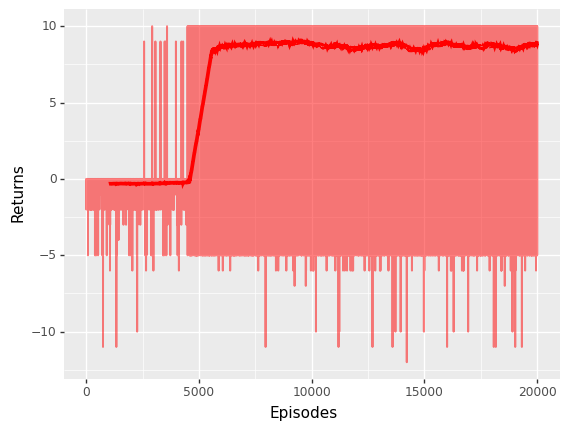

<ggplot: (8772478088285)>

In [ ]:
#@title Plot episode returns during the training phase
plot_training_return = (gg.ggplot(df_teacher_training)
               + gg.aes(x='episode', y='return')
               + gg.geom_line(size=0.8, alpha=0.5, color='red')
               + gg.ylab('Returns')
               + gg.xlab('Episodes')
               + gg.stat_smooth(color='red', size=1.5, se=False, method='mavg', method_args={'window': 1000})
              )
plot_training_return

## 4. Implementing distillation methods with different control policies

Now that we have a valid teacher for our grid environment, we can transfer its knowledge to a student policy $\pi_{\theta}$. I use the same three different control policies the authors used in the paper, but also included a fourth one. Control policies $q_{\theta}$ are respectively
* the teacher,
* the student, 
* a uniform distribution over all possible actions,
* a **mixture of the teacher and the student**.

We want to reproduce similar plots to the Figure 3. Therefore we will use the same update rule to update parameters $\theta$ of the student policy. Let $H^{\times}(p_1(s) || p_2(s))$ denote Shannon's cross-entropy, more specifically

\begin{equation*}
  H^{\times}(p_1(s) || p_2(s)) = -\mathbb{E}_{a \sim p_1(s)} \left[ \log(p_2(a | s)) \right].
\end{equation*}

Then the update rule is proportional to

\begin{equation*}
  \mathbb{E}_{q_{\theta}} \left[ \sum_{t=1}^{|\tau|} \nabla_{\theta} H^{\times}(\pi(s_t) || \pi_{\theta}(s_t)) \right].
\end{equation*}

Once again, we recall that $q_{\theta}$ is the control policy, $\pi_{\theta}$ the student policy, and $\pi$ the teacher policy

In [ ]:
#@title Hyperparameters of the empirical study

n_episodes = 2000 #@param {type:"integer"}
update_learn_rate = 0.01 #@param {type:"number"}
control_policies = ['teacher', 'student', 'uniform', 'mixture'] #@param {type:"raw"}
mixt_weight_student = 0.5 #@param {type:"number"}

df_control_policies = pd.DataFrame([])

In [ ]:
#@title Utils functions (e.g. softmax, grad_cross_entropy, compute_KL, etc.)

# Greedy policy (for the teacher policy)
def hardmax(x):
  e_x = (x == np.max(x)).astype(int)
  return e_x / e_x.sum()

# Softmax function (for the student policy)
def softmax(x):
  e_x = np.exp(x - np.max(x))
  return e_x / e_x.sum()

# Gradient of the cross-entropy
def grad_cross_entropy(qx, px):
  soft_qx = hardmax(qx)
  soft_px = softmax(px)
  gradient = -soft_qx + np.sum(soft_qx * soft_px)
  return gradient

# Sample a trajectory from a control policy
def get_control_trajectory(control, teacher, student):
  
  # Initialize the environment
  env.state = env.initial_state
  env.steps = 1
  observation = env.state[0]*env.n_rows + env.state[1]
  done = env.isDone()
  episode_return = 0
  memory = []

  while not done:
    # Choose an action according to the control policy
    if (control == 'teacher'):
      qs = teacher[observation]
      action = np.random.choice(np.argwhere(qs == np.max(qs)).flatten().tolist())
    elif (control == 'student'):
      qs = student[observation]
      action = tf.squeeze(tf.random.categorical([qs], 1)).numpy()
    elif (control == 'uniform'):
      action = np.random.randint(act_size)
      
    # Agent-environment interaction
    env.nxtPosition(action)
    new_observation = env.state[0]*env.n_rows + env.state[1]
    done = env.isDone()
    # Store results
    memory.append(observation)
    observation = new_observation

  return np.asarray(memory)

# Compute the KL divergence according to a distribution
def compute_KL(dist, teacher, student):
  obs = get_control_trajectory(dist, teacher, student)
  loss = 0
  for o_t in obs:
    q_teacher = hardmax(teacher[o_t])
    q_student = softmax(student[o_t])
    loss -= np.mean(q_teacher * np.log(q_student))
  return loss

In [ ]:
#@title Run policy distillation for all methods

# Loop for all control policies
for control in control_policies:
  print('Control policy: {}.'.format(control))

  # Initialize the student 
  student_table = np.zeros([obs_size, act_size])

  # Episode stats
  results = []

  # Run loop for all episodes
  for episode in range(n_episodes):
    # Initialize the environment
    env.state = env.initial_state
    env.steps = 1
    observation = env.state[0]*env.n_rows + env.state[1]
    done = env.isDone()
    episode_return = 0

    while not done:
      # Choose an action according to the control policy
      mixt_rand = np.random.rand()
      if (control == 'teacher') or (control == 'mixture' and mixt_rand > mixt_weight_student):
        qs = teacher_table[observation]
        action = np.random.choice(np.argwhere(qs == np.max(qs)).flatten().tolist())
      elif (control == 'student') or (control == 'mixture' and mixt_rand <= mixt_weight_student):
        qs = student_table[observation]
        action = tf.squeeze(tf.random.categorical([qs], 1)).numpy()
      elif (control == 'uniform'):
        action = np.random.randint(act_size)
      
      # Agent-environment interaction
      env.nxtPosition(action)
      new_observation = env.state[0]*env.n_rows + env.state[1]
      reward = env.giveReward()
      done = env.isDone()
      
      # Update the student policy according to the gradient of cross-entropy
      update = grad_cross_entropy(teacher_table[observation], student_table[observation])
      student_table[observation] -= update_learn_rate*update

      episode_return += reward
      observation = new_observation

    # Compute KL divergence with different distributions
    loss_unif = compute_KL('uniform', teacher_table, student_table)
    loss_teacher = compute_KL('teacher', teacher_table, student_table)
    loss_student = compute_KL('student', teacher_table, student_table)

    # Store results
    results.append({'episode': episode, 
                    'loss_unif': loss_unif,
                    'loss_teacher': loss_teacher,
                    'loss_student': loss_student,
                    'return': episode_return,
                    'control': control}) 
    # Show results     
    if episode % 500 == 0 or episode == n_episodes - 1:
      print('Episode: {}.\tKL-unif: {:.2f}.\tKL-teach: {:.2f}.\tKL-stud: {:.2f}.\tEpisode return: {}.'.format(episode, loss_unif, loss_teacher, loss_student, episode_return))

  df_control_policies = df_control_policies.append(pd.DataFrame(results))

Control policy: teacher.
Episode: 0.	KL-unif: 6.58.	KL-teach: 2.41.	KL-stud: 6.58.	Episode return: 10.
Episode: 500.	KL-unif: 2.78.	KL-teach: 0.03.	KL-stud: 2.45.	Episode return: 10.
Episode: 1000.	KL-unif: 6.24.	KL-teach: 0.00.	KL-stud: 0.00.	Episode return: 10.
Episode: 1500.	KL-unif: 1.39.	KL-teach: 0.00.	KL-stud: 0.00.	Episode return: 10.
Episode: 1999.	KL-unif: 1.39.	KL-teach: 0.00.	KL-stud: 0.00.	Episode return: 10.
Control policy: student.
Episode: 0.	KL-unif: 3.45.	KL-teach: 2.42.	KL-stud: 0.69.	Episode return: 8.
Episode: 500.	KL-unif: 1.56.	KL-teach: 0.08.	KL-stud: 0.08.	Episode return: 10.
Episode: 1000.	KL-unif: 0.98.	KL-teach: 0.00.	KL-stud: 0.00.	Episode return: 10.
Episode: 1500.	KL-unif: 0.26.	KL-teach: 0.00.	KL-stud: 0.00.	Episode return: 10.
Episode: 1999.	KL-unif: 2.30.	KL-teach: 0.00.	KL-stud: 0.00.	Episode return: 10.
Control policy: uniform.
Episode: 0.	KL-unif: 6.56.	KL-teach: 2.42.	KL-stud: 4.15.	Episode return: 0.
Episode: 500.	KL-unif: 3.25.	KL-teach: 1.19.	KL

## 5. Comparison of distillation methods

During the distillation procedure, we measure for various choices of $z_{\theta}$ the following expectation:

\begin{equation*}
  \mathbb{E}_{z_{\theta}} \left[ \sum_{t=1}^{|\tau|} \nabla_{\theta} H^{\times}(\pi(s_t) || \pi_{\theta}(s_t)) \right].
\end{equation*}

This gives an idea of the alignment between the student and teacher policies at each episode. We plot this expected KL for three different distributions $z_{\theta}$, more specifically

* the teacher,
* the student, 
* a uniform distribution over all possible actions.

We want to create similar plots to the first row of plots in the Figure 3 of the original paper. Since this notebook only executes policy distillation for one particular MDP, we add on the plots moving average curves to see patterns.

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


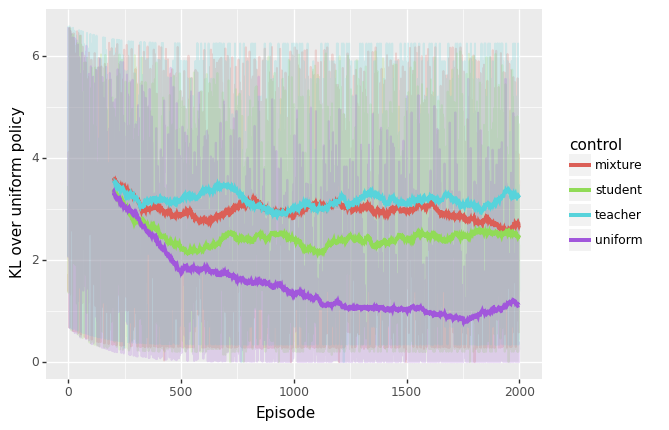

<ggplot: (8772441766537)>

In [ ]:
#@title Visualization of the KL over uniform policy
plot_KL_uniform = (gg.ggplot(df_control_policies)
               + gg.aes(x='episode', y='loss_unif', colour='control')
               + gg.geom_line(size=0.8, alpha=0.2)
               + gg.ylab('KL over uniform policy')
               + gg.xlab('Episode')
               + gg.stat_smooth(size=1.5, method='mavg', se=False, method_args={'window': 200})
              )
plot_KL_uniform

As noted in the original paper, matching of the teacher policy outside of typically visited states is much better when following a student-driven policy. We see that the mixture is performing a little better than a pure teacher-driven distillation, but it does not achieve similar results to the student-driven distillation. It is measured here by the expected KL over a uniform policy. 

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


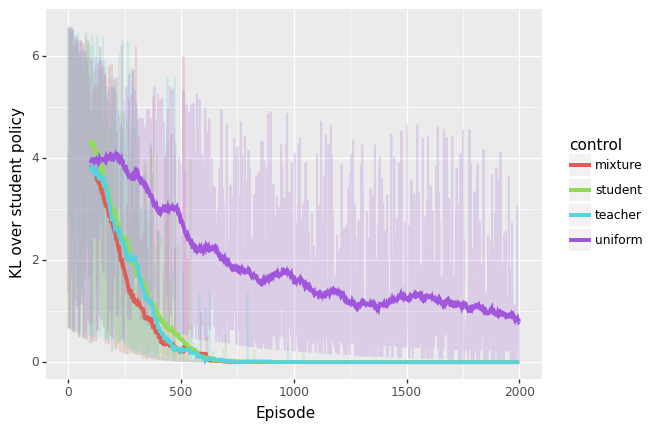

<ggplot: (8772383263069)>

In [ ]:
#@title Visualization of the KL over student policy

plot_KL_student = (gg.ggplot(df_control_policies)
               + gg.aes(x='episode', y='loss_student', colour='control')
               + gg.geom_line(size=0.8, alpha=0.2)
               + gg.ylab('KL over student policy')
               + gg.xlab('Episode')
               + gg.stat_smooth(size=1.5, method='mavg', se=False, method_args={'window': 100})
              )
plot_KL_student

We get that all three policies are similar with a small advantage to the mixture-driven distillation. We should point out that this notebook is done on a single MDP instance that is less complex that the one analyzed by the authors. We must perform this notebook for a sufficient number of different MDPs in order to get a better idea of which methods are significantly better. 

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


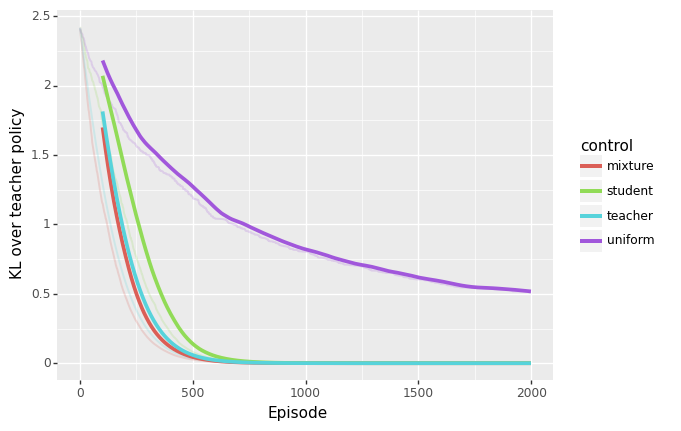

<ggplot: (8772441706613)>

In [ ]:
#@title Visualization of the KL over teacher policy

plot_KL_teacher = (gg.ggplot(df_control_policies)
               + gg.aes(x='episode', y='loss_teacher', colour='control')
               + gg.geom_line(size=0.8, alpha=0.2)
               + gg.ylab('KL over teacher policy')
               + gg.xlab('Episode')
               + gg.stat_smooth(size=1.5, method='mavg', se=False, method_args={'window': 100})
              )
plot_KL_teacher

This last criterion, the expected KL under trajectories generated from the teacher policy, indicates that teacher-driven (and mixture-driven) distillation works more effectively, as we could expect. However as noted by the authors: "this is an artifical scenario which is rarely encountered in practice".